In [7]:
import pandas as pd
import numpy as np

!ls /content

df = pd.read_csv('/content/Simulated_A_B_Test_Dataset.csv')
df.head()

print(df['group'].value_counts())

sample_data  Simulated_A_B_Test_Dataset.csv  Simulated_Sessions.csv
group
blue-large    80
blue-small    80
red-large     80
red-small     80
Name: count, dtype: int64


In [8]:
target_sizes = {
  'blue-small': 75,
  'blue-large': 70,
  'red-small': 78,
  'red-large': 72
}


df_adjusted = (
    df
    .groupby('group', group_keys=False)
    .apply(lambda x: x.sample(n=target_sizes[x.name], random_state=42))
    .reset_index(drop=True)
)

<ipython-input-8-dc9f8381ac3c>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=target_sizes[x.name], random_state=42))


In [9]:
ctr_params = {'blue-small':0.42, 'blue-large':0.48, 'red-small':0.56, 'red-large':0.62}
time_params = {
    'blue-small':(28,8), 'blue-large':(26,7),
    'red-small':(24,6),  'red-large':(22,5)
}

sim_dfs = []
for grp, df_grp in df_adjusted.groupby('group'):
    n = len(df_grp)
    p_click = ctr_params[grp]
    mu, sigma = time_params[grp]
    clicked = np.random.binomial(1, p_click, size=n)
    time_spent = np.where(clicked==1,
                          np.random.normal(mu, sigma, size=n),
                          np.nan)
    sim_dfs.append(pd.DataFrame({
        'session_id': df_grp['session_id'],
        'group': grp,
        'clicked': clicked,
        'time_spent': time_spent
    }))
df_simulated = pd.concat(sim_dfs, ignore_index=True)


In [10]:
new_n = 150

sim_dfs = []
for grp in ['blue-small','blue-large','red-small','red-large']:
    p_click = ctr_params[grp]
    mu, sigma = time_params[grp]
    clicked = np.random.binomial(1, p_click, size=new_n)
    time_spent = np.where(clicked==1,
                          np.random.normal(mu, sigma, size=new_n),
                          np.nan)
    sim_dfs.append(pd.DataFrame({
        'session_id': [f"{grp}_{i}" for i in range(new_n)],
        'group':      grp,
        'clicked':    clicked,
        'time_spent': time_spent
    }))
df_simulated = pd.concat(sim_dfs, ignore_index=True)
df_simulated[['color','size']] = df_simulated.group.str.split('-', expand=True)
df_simulated.to_csv('/content/Simulated_A_B_Test_Dataset.csv', index=False)


In [11]:
df_simulated[['color','size']] = df_simulated['group'].str.split('-', expand=True)
df_simulated.to_csv('/content/Simulated_A_B_Test_Dataset.csv', index=False)

print(df_simulated.groupby('group').agg(
    n_sessions=('session_id','size'),
    ctr=('clicked','mean'),
    avg_time=('time_spent','mean')
))

            n_sessions       ctr   avg_time
group                                      
blue-large         150  0.473333  26.507882
blue-small         150  0.413333  26.613370
red-large          150  0.566667  23.262005
red-small          150  0.493333  23.674202


In [12]:
import pandas as pd
from google.colab import files

df_simulated.to_csv('Simulated_Sessions.csv', index=False)

files.download('Simulated_Sessions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Logistic regression on click-through (clicked ~ color * size)
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

df = pd.read_csv('/content/Simulated_Sessions.csv')

df[['color', 'size']] = df['group'].str.split('-', expand=True)

model_ctr = smf.glm(
    formula='clicked ~ C(color)*C(size)',
    data=df,
    family=sm.families.Binomial()
).fit()

print("=== Click-Through Logistic Regression ===")
print(model_ctr.summary().tables[1], "\n")

=== Click-Through Logistic Regression ===
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.1068      0.164     -0.653      0.514      -0.427       0.214
C(color)[T.red]                      0.3750      0.232      1.615      0.106      -0.080       0.830
C(size)[T.small]                    -0.2434      0.233     -1.045      0.296      -0.700       0.213
C(color)[T.red]:C(size)[T.small]    -0.0515      0.329     -0.157      0.876      -0.696       0.593



In [14]:
# Two-way ANOVA on log(time_spent), only for sessions that clicked
df_clicked = df[df['clicked'] == 1].copy()
df_clicked['log_time'] = np.log(df_clicked['time_spent'] + 1e-6)

model_time = smf.ols(
    formula='log_time ~ C(color) * C(size)',
    data=df_clicked
).fit()
anova_results = anova_lm(model_time, typ=2)
print("\n=== log(time_spent) Two-Way ANOVA ===")
print(anova_results)


=== log(time_spent) Two-Way ANOVA ===
                     sum_sq     df         F    PR(>F)
C(color)           0.850281    1.0  8.194381  0.004510
C(size)            0.001310    1.0  0.012626  0.910611
C(color):C(size)   0.004799    1.0  0.046247  0.829880
Residual          29.884009  288.0       NaN       NaN


In [15]:
df_simulated.to_csv('Simulated_Sessions.csv', index=False)

df = pd.read_csv('Simulated_A_B_Test_Dataset.csv')

print("Columns in df:", df.columns.tolist())

Columns in df: ['session_id', 'group', 'clicked', 'time_spent', 'color', 'size']


In [16]:

# Logistic regression on completion (completed ~ color * size)
if 'completed' not in df.columns:
    df['completed'] = df['clicked']

model_completed = smf.glm(
    'completed ~ C(color)*C(size)',
    data=df,
    family=sm.families.Binomial()
).fit()
print(model_completed.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              completed   No. Observations:                  600
Model:                            GLM   Df Residuals:                      596
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -412.06
Date:                Fri, 25 Apr 2025   Deviance:                       824.12
Time:                        16:57:29   Pearson chi2:                     600.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01198
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [17]:
model_click = smf.glm(
    'clicked ~ C(color)*C(size)',
    data=df,
    family=sm.families.Binomial()
).fit()

odds_ratios = np.exp(model_click.params)

In [20]:
# Compute effect sizes
# a. Odds Ratios for click model
odds_ratios = np.exp(model_click.params)
print("\n=== Odds Ratios (Click Model) ===")
print(odds_ratios)

# b. Eta-squared for log(time_spent) ANOVA
ss = anova_results['sum_sq']
eta_squared = ss / ss.sum()
print("\n=== Eta-Squared (log_time ANOVA) ===")
print(eta_squared)


=== Odds Ratios (Click Model) ===
Intercept                           0.898734
C(color)[T.red]                     1.455038
C(size)[T.small]                    0.783931
C(color)[T.red]:C(size)[T.small]    0.949806
dtype: float64

=== Eta-Squared (log_time ANOVA) ===
C(color)            0.027660
C(size)             0.000043
C(color):C(size)    0.000156
Residual            0.972141
Name: sum_sq, dtype: float64


McFadden pseudo R²: 0.008697845568306661 

         GLM Marginal Effects        
Dep. Variable:                clicked
Method:                          dydx
At:                           overall
                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
C(color)[T.red]                      0.0926      0.057      1.630      0.103      -0.019       0.204
C(size)[T.small]                    -0.0601      0.057     -1.049      0.294      -0.172       0.052
C(color)[T.red]:C(size)[T.small]    -0.0127      0.081     -0.157      0.876      -0.172       0.146



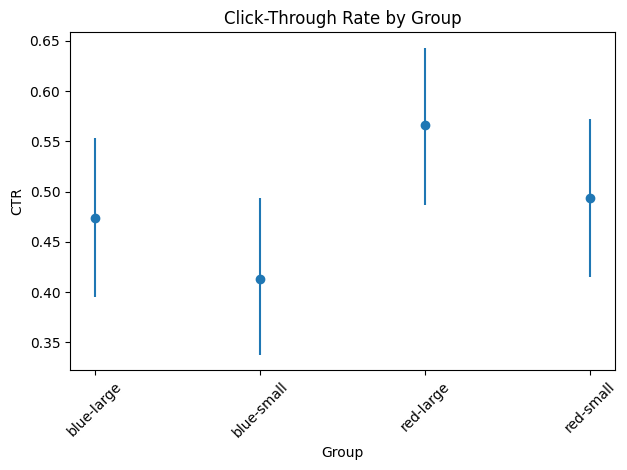

<ipython-input-22-19d7ac0c6e04>:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


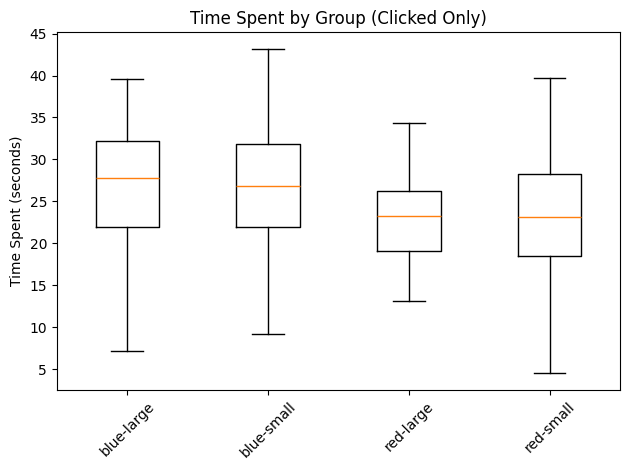

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import levene
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import statsmodels.api as sm2

# 1. Load session-level data (make sure 'completed' is present)
df = pd.read_csv('Simulated_Sessions.csv')
df[['color','size']] = df['group'].str.split('-', expand=True)

# 2. Fit click model
model_click = smf.glm(
    'clicked ~ C(color)*C(size)',
    data=df, family=sm.families.Binomial()
).fit()

# 3. McFadden's pseudo R²
llf = model_click.llf
llnull = model_click.null_deviance / -2
pseudo_r2 = 1 - llf / llnull
print("McFadden pseudo R²:", pseudo_r2, "\n")

# 4. Marginal effects
margeff = model_click.get_margeff(at='overall')
print(margeff.summary(), "\n")

# 5. Bar chart of click-through rates with 95% CI
grouped = df.groupby('group')['clicked']
ctr = grouped.mean()
n = grouped.size()
ci_low, ci_up = proportion_confint(grouped.sum(), n, method='wilson')

plt.figure()
plt.errorbar(ctr.index, ctr.values,
             yerr=[ctr.values - ci_low, ci_up - ctr.values],
             fmt='o')
plt.title('Click-Through Rate by Group')
plt.xlabel('Group')
plt.ylabel('CTR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Boxplot of time_spent for clicked sessions
df_click = df[df.clicked==1].copy()
plt.figure()
plt.boxplot(
    [df_click.loc[df_click['group']==g, 'time_spent'].dropna() for g in ctr.index],
    labels=ctr.index
)
plt.title('Time Spent by Group (Clicked Only)')
plt.ylabel('Time Spent (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# 3.5 Bounce-Rate Logistic Regression
# 0) After you load df, before fitting any model:
#    derive bounce_detected = 1 if clicked==0, else 0
if 'bounce_detected' not in df.columns:
    df['bounce_detected'] = (df['clicked'] == 0).astype(int)

# now you can fit the bounce model
model_bounce = smf.glm(
    'bounce_detected ~ C(color)*C(size)',
    data=df,
    family=sm.families.Binomial()
).fit()

model_bounce = smf.glm(
    'bounce_detected ~ C(color)*C(size)',
    data=df,
    family=sm.families.Binomial()
).fit()

print("=== Bounce-Rate Logistic Regression ===")
print(model_bounce.summary().tables[1], "\n")

# Odds ratios + 95% CI
params = model_bounce.params
conf   = model_bounce.conf_int()
or_bounce = pd.DataFrame({
    'OR'      : np.exp(params),
    'CI_low'  : np.exp(conf[0]),
    'CI_high' : np.exp(conf[1])
})
print("=== Odds Ratios (Bounce Model) ===")
print(or_bounce, "\n")

# McFadden pseudo-R²
llf    = model_bounce.llf
llnull = model_bounce.null_deviance / -2
print("McFadden pseudo-R² (bounce):", 1 - llf/llnull)


=== Bounce-Rate Logistic Regression ===
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1068      0.164      0.653      0.514      -0.214       0.427
C(color)[T.red]                     -0.3750      0.232     -1.615      0.106      -0.830       0.080
C(size)[T.small]                     0.2434      0.233      1.045      0.296      -0.213       0.700
C(color)[T.red]:C(size)[T.small]     0.0515      0.329      0.157      0.876      -0.593       0.696

=== Odds Ratios (Bounce Model) ===
                                        OR    CI_low   CI_high
Intercept                         1.112676  0.807551  1.533089
C(color)[T.red]                   0.687267  0.436036  1.083251
C(size)[T.small]                  1.275623  0.808147  2.013512
C(color)[T.red]:C(size)[T.small]  1.052847  0.552789  2.005263 

M

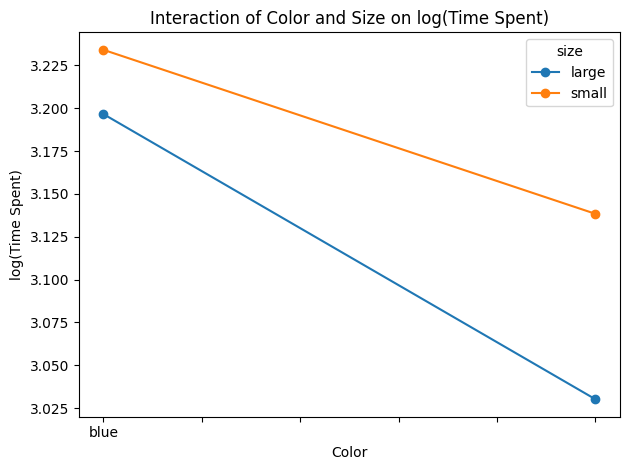

In [ ]:
import matplotlib.pyplot as plt

# assume df_click and df_click['log_time'] already exist
# 1) compute mean log_time for each color × size
means = (
    df_clicked
    .groupby(['color','size'])['log_time']
    .mean()
    .unstack('size')    # rows=color, cols=size
)

# 2) plot the two lines
ax = means.plot(marker='o')
ax.set_title('Interaction of Color and Size on log(Time Spent)')
ax.set_xlabel('Color')
ax.set_ylabel('log(Time Spent)')
plt.tight_layout()
plt.show()

Levene test (log_time) by color: LeveneResult(statistic=np.float64(1.6039353558341936), pvalue=np.float64(0.20631912590340015))
Levene test (log_time) by size: LeveneResult(statistic=np.float64(0.0989983165047979), pvalue=np.float64(0.753251570093855)) 



<Figure size 640x480 with 0 Axes>

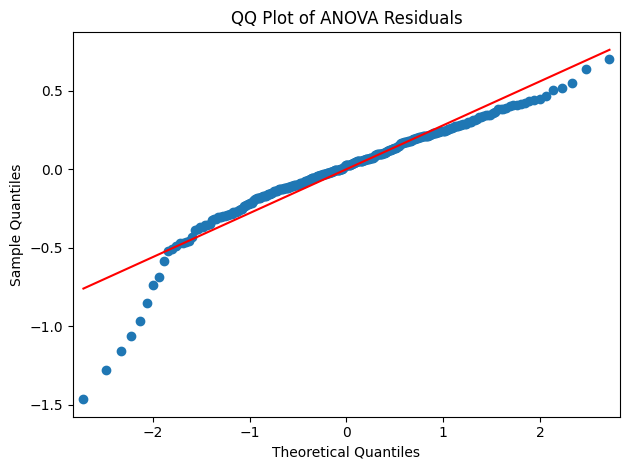

In [ ]:
# Levene’s test for homogeneity of variance
print("Levene test (log_time) by color:",
      levene(*[df_clicked[df_clicked['color']==c]['log_time'] for c in df_clicked['color'].unique()]))
print("Levene test (log_time) by size:",
      levene(*[df_clicked[df_clicked['size']==s]['log_time'] for s in df_clicked['size'].unique()]), "\n")

# QQ plot of residuals for ANOVA model
model_time = smf.ols('log_time ~ C(color)*C(size)', data=df_clicked).fit()
plt.figure()
sm2.qqplot(model_time.resid, line='s')
plt.title('QQ Plot of ANOVA Residuals')
plt.tight_layout()
plt.show()

Overall CTR:
 clicked
1    0.515
0    0.485
Name: proportion, dtype: float64
Overall completion rate:
 clicked
1    0.515
0    0.485
Name: proportion, dtype: float64
count    309.000000
mean      24.745916
std        6.989401
min        6.520729
25%       19.774793
50%       24.170675
75%       29.192617
max       44.772616
Name: time_spent, dtype: float64


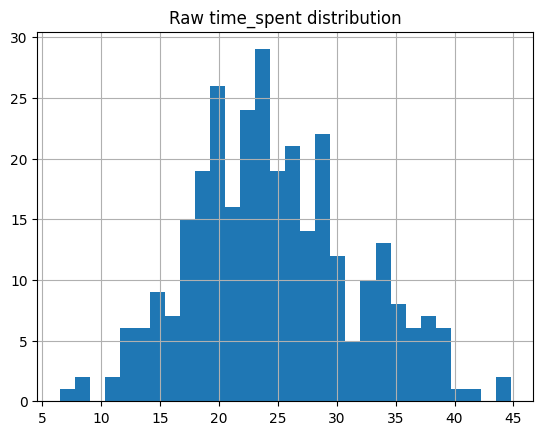

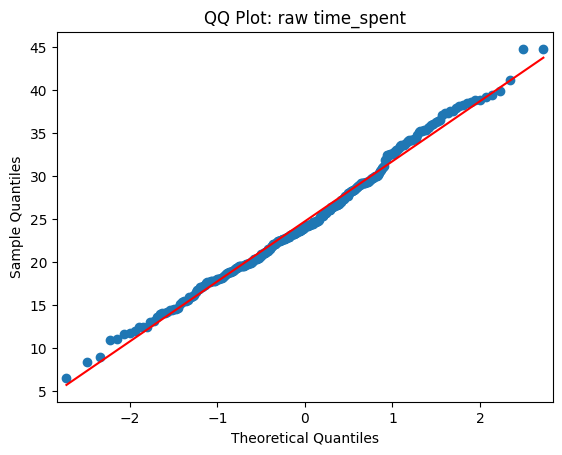

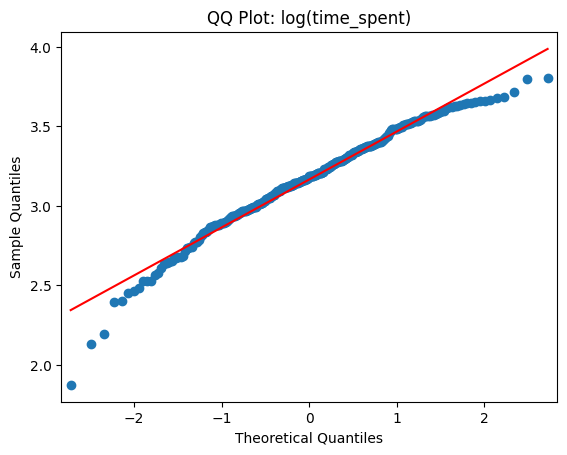

Number of time_spent outliers: 2


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm2

# -- EXPLORE METRICS --
# 1. Overall CTR & completion rate
print("Overall CTR:\n", df['clicked'].value_counts(normalize=True))
print("Overall completion rate:\n", df['clicked'].value_counts(normalize=True))

# 2. time_spent distribution
print(df['time_spent'].describe())
df['time_spent'].hist(bins=30)
plt.title("Raw time_spent distribution")
plt.show()

# 3. QQ–plot on raw vs log
sm2.qqplot(df['time_spent'].dropna(), line='s')
plt.title("QQ Plot: raw time_spent")
plt.show()

sm2.qqplot(np.log(df['time_spent'].dropna()+1e-6), line='s')
plt.title("QQ Plot: log(time_spent)")
plt.show()

# 4. (Optional) Outlier check
Q1, Q3 = df['time_spent'].quantile([.25,.75])
IQR = Q3 - Q1
outliers = df.loc[(df.time_spent < Q1-1.5*IQR) | (df.time_spent > Q3+1.5*IQR)]
print("Number of time_spent outliers:", len(outliers))
